In [1]:
import string
import random
from timeit import default_timer as timer
from time import sleep, process_time
from matplotlib import pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
import pandas as pd
import scipy

In [2]:
alphabet = string.ascii_uppercase + string.ascii_lowercase + string.digits
print(f"Alphabet: {alphabet}")

Alphabet: ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789


In [3]:
unknown_password = ''.join(random.choices(alphabet, k=24))
print(f"Unknown password: {unknown_password}")

Unknown password: kHvi4e2cvaUnUQWlMZmi34jC


In [4]:
def password_compare(unknown_password, guess_password):
    
    i = 0
    
    while i < len(unknown_password) and i < len(guess_password):
       
        if unknown_password[i] != guess_password[i]:
            return
                
        i += 1

In [5]:
def password_query(guess_password):
    
    start = process_time()
    password_compare(unknown_password, guess_password)
    end = process_time()

    return (end - start)

In [6]:
n_queries = 500
deltas = []

for character in alphabet:
    
    for _ in range(n_queries):

        # Note: '!' is NOT in the alphabet! This is important!
        guess_password_km1 = unknown_password[:12] + ('!' * 12)
        t_km1 = password_query(guess_password_km1)

        guess_password_k = unknown_password[:12] + character + ('!' * 11)        
        t_k = password_query(guess_password_k)

        deltas += [(t_k - t_km1)]

In [9]:
delta_range = np.median(deltas) - 1.5 * (np.quantile(deltas, 0.95) - np.quantile(deltas, 0.05)), \
              np.median(deltas) + 1.5 * (np.quantile(deltas, 0.95) - np.quantile(deltas, 0.05))
print(f"Range: {delta_range}")

Range: (-9.320750002927969e-07, 9.220750012417501e-07)


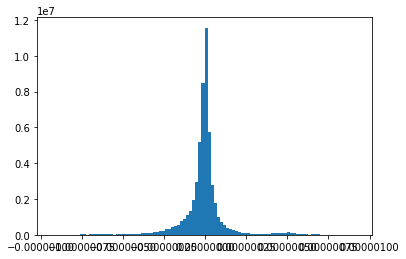

In [10]:
_ = plt.hist(deltas, range=delta_range, density=True, bins=100)

In [11]:
next_char_index = alphabet.find(unknown_password[12])
print(f"Next character index: {next_char_index}")

Next character index: 20


In [12]:
incorrect_deltas = deltas[:next_char_index * n_queries] + deltas[(next_char_index + 1) * n_queries:]
correct_deltas = deltas[next_char_index * n_queries:(next_char_index + 1) * n_queries]

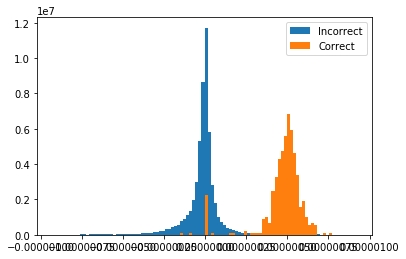

In [13]:
_ = plt.hist(incorrect_deltas, range=delta_range, density=True, bins=100, label='Incorrect')
_ = plt.hist(correct_deltas, range=delta_range, density=True, bins=100, label='Correct')
_ = plt.legend()

In [14]:
clean_deltas = list(filter(lambda delta: delta > delta_range[0] and delta < delta_range[1], deltas))

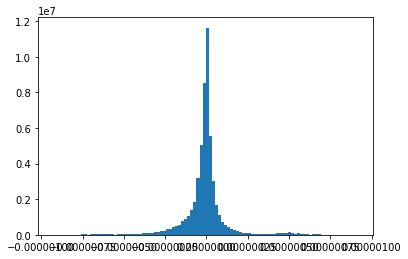

In [15]:
_ = plt.hist(clean_deltas, density=True, bins=100)

In [17]:
clean_std = np.std(clean_deltas)
print(f"Clean delta standard deviation: {clean_std}")

Clean delta standard deviation: 1.3710466936383165e-07


In [18]:
std_clean_deltas = np.array(clean_deltas) / clean_std

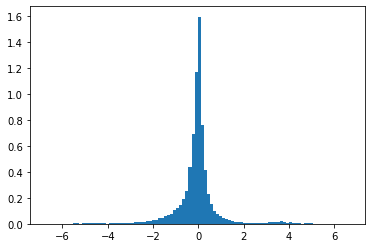

In [19]:
_ = plt.hist(std_clean_deltas, density=True, bins=100)

In [27]:
clean_delta_range = delta_range[0] / clean_std, delta_range[1] / clean_std

In [20]:
medians = []

for i in range(len(alphabet)):
    
    medians += [np.median(deltas[i * n_queries : (i + 1) * n_queries])]

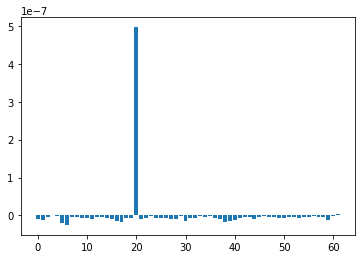

In [21]:
_ = plt.bar(range(len(alphabet)), medians)

In [22]:
print(f"Next character guess: {np.argmax(medians)}")

Next character guess: 20


In [24]:
gmm = GaussianMixture(n_components=2)
_ = gmm.fit(np.array(std_clean_deltas).reshape(-1, 1))

In [25]:
print(f"Means: {gmm.means_[0, 0]}, {gmm.means_[1, 0]}")
print(f"Variances: {gmm.covariances_[0, 0, 0]}, {gmm.covariances_[1, 0, 0]}")
print(f"Weights: {gmm.weights_[0]}, {gmm.weights_[1]}")

Means: -0.1889866310947672, 3.627313282661675
Variances: 0.6185513150746734, 0.9064657020942917
Weights: 0.9736350803620951, 0.026364919637867485


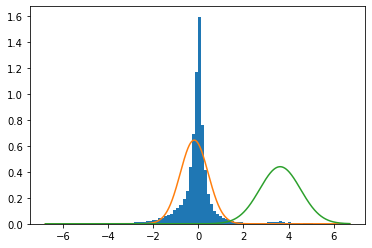

In [28]:
_ = plt.hist(std_clean_deltas, bins=100, density=True)

xx = np.arange(clean_delta_range[0], clean_delta_range[1], 0.01)

_ = plt.plot(xx, scipy.stats.norm.pdf(xx, gmm.means_[0,0], gmm.covariances_[0,0,0]))
_ = plt.plot(xx, scipy.stats.norm.pdf(xx, gmm.means_[1,0], gmm.covariances_[1,0,0]))

In [29]:
correct_distribution = np.argmin(gmm.weights_)
print(f"Correct distribution: {correct_distribution}")

Correct distribution: 1


In [33]:
probs = []

for i in range(len(alphabet)):
    
    if correct_distribution == 1:
        probs += [np.sum(gmm.predict(np.array(deltas[i * n_queries : (i + 1) * n_queries]).reshape(-1, 1) / clean_std)) / n_queries]
    else:
        probs += [np.sum(1 - gmm.predict(np.array(deltas[i * n_queries : (i + 1) * n_queries]).reshape(-1, 1) / clean_std)) / n_queries]

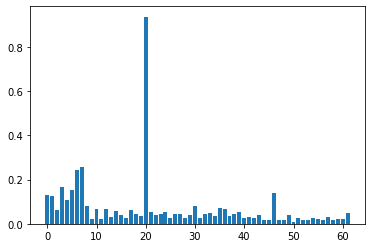

In [34]:
_ = plt.bar(range(0, len(alphabet)), probs)

In [35]:
print(f"Next character guess: {np.argmax(probs)}")

Next character guess: 20


In [50]:
def password_compare(unknown_password, guess_password):
    
    return (unknown_password == guess_password)

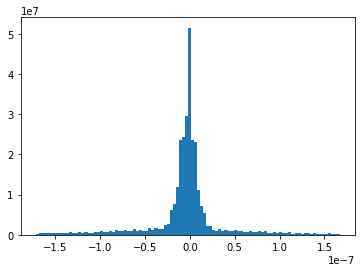

In [116]:
n_queries = 1000
deltas = []

for character in alphabet:
    
    for _ in range(n_queries):

        # Note: '!' is NOT in the alphabet! This is important!
        guess_password_km1 = unknown_password[:12] + ('!' * 12)
        t_km1 = password_query(guess_password_km1)

        guess_password_k = unknown_password[:12] + character + ('!' * 11)        
        t_k = password_query(guess_password_k)

        deltas += [(t_k - t_km1)]

delta_range = np.median(deltas) - 1.5 * (np.quantile(deltas, 0.9) - np.quantile(deltas, 0.1)), \
              np.median(deltas) + 1.5 * (np.quantile(deltas, 0.9) - np.quantile(deltas, 0.1))

_ = plt.hist(deltas, range=delta_range, density=True, bins=100)

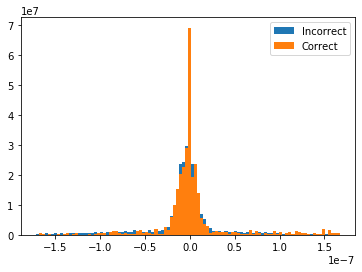

In [117]:
incorrect_deltas = deltas[:next_char_index * n_queries] + deltas[(next_char_index + 1) * n_queries:]
correct_deltas = deltas[next_char_index * n_queries:(next_char_index + 1) * n_queries]

_ = plt.hist(incorrect_deltas, range=delta_range, density=True, bins=100, label='Incorrect')
_ = plt.hist(correct_deltas, range=delta_range, density=True, bins=100, label='Correct')
_ = plt.legend()

In [118]:
clean_deltas = list(filter(lambda delta: delta > delta_range[0] and delta < delta_range[1], deltas))

In [119]:
clean_std = np.std(clean_deltas)
print(f"Clean delta standard deviation: {clean_std}")

Clean delta standard deviation: 4.123092946638506e-08


In [120]:
std_clean_deltas = np.array(clean_deltas) / clean_std

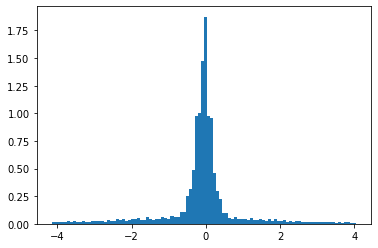

In [121]:
_ = plt.hist(std_clean_deltas, density=True, bins=100)

In [122]:
gmm = GaussianMixture(n_components=2)
_ = gmm.fit(np.array(std_clean_deltas).reshape(-1, 1))

In [123]:
print(f"Means: {gmm.means_[0, 0]}, {gmm.means_[1, 0]}")
print(f"Variances: {gmm.covariances_[0, 0, 0]}, {gmm.covariances_[1, 0, 0]}")
print(f"Weights: {gmm.weights_[0]}, {gmm.weights_[1]}")

Means: -2.7639216616338116, 0.05944759042636115
Variances: 0.5192018450230972, 0.579763269245817
Weights: 0.056317630573016204, 0.9436823694270431


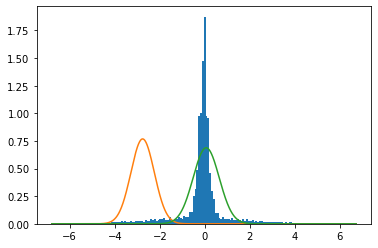

In [124]:
_ = plt.hist(std_clean_deltas, bins=100, density=True)

xx = np.arange(clean_delta_range[0], clean_delta_range[1], 0.01)

_ = plt.plot(xx, scipy.stats.norm.pdf(xx, gmm.means_[0,0], gmm.covariances_[0,0,0]))
_ = plt.plot(xx, scipy.stats.norm.pdf(xx, gmm.means_[1,0], gmm.covariances_[1,0,0]))

In [125]:
correct_distribution = np.argmin(gmm.weights_)
print(f"Correct distribution: {correct_distribution}")

Correct distribution: 0


In [126]:
probs = []

for i in range(len(alphabet)):
    
    if correct_distribution == 1:
        probs += [np.sum(gmm.predict(np.array(deltas[i * n_queries : (i + 1) * n_queries]).reshape(-1, 1) / clean_std)) / n_queries]
    else:
        probs += [np.sum(1 - gmm.predict(np.array(deltas[i * n_queries : (i + 1) * n_queries]).reshape(-1, 1) / clean_std)) / n_queries]

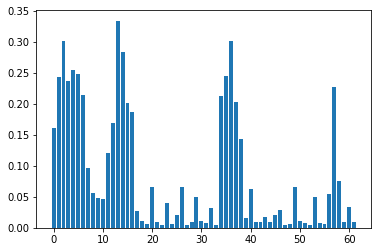

In [127]:
_ = plt.bar(range(0, len(alphabet)), probs)

In [128]:
print(f"Next character guess: {np.argmax(probs)}")

Next character guess: 13


## Naive Approach (Fast)

Let's try our naive approach again and see if the results are as clear as before.

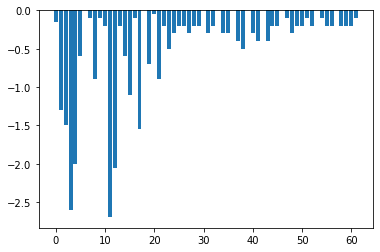

In [31]:
medians = []

for i in range(len(alphabet)):
    
    medians += [np.median(deltas[i * n_queries : (i + 1) * n_queries])]
    
_ = plt.bar(range(len(alphabet)), medians)

Let's try our same decision process from before and select the character with the largest median.

In [32]:
print(f"Next character guess: {np.argmax(medians)}")

Next character guess: 6


Unfortunately, this is not the correct answer. Maybe the mean is the better approach?

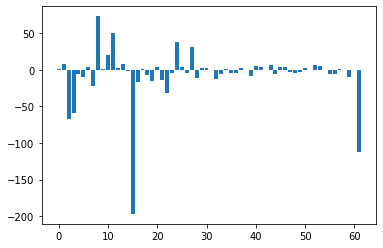

In [33]:
means = []

for i in range(len(alphabet)):
    
    means += [np.mean(deltas[i * n_queries : (i + 1) * n_queries])]
    
_ = plt.bar(range(len(alphabet)), means)

In [34]:
print(f"Next character guess: {np.argmax(means)}")

Next character guess: 8


Again, this is not the correct answer. (Also notice how this result is worse because of outliers!) What about the magnitude of the inner 90\% of the data? (Think of this as standard deviation resistant to outliers.)

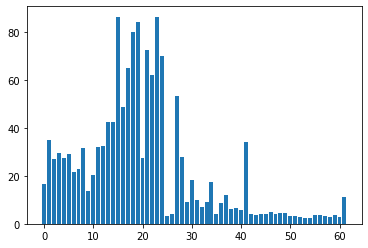

In [35]:
iqs = []

for i in range(len(alphabet)):
    
    iqs += [np.quantile(deltas[i * n_queries : (i + 1) * n_queries], 0.95) \
            - np.quantile(deltas[i * n_queries : (i + 1) * n_queries], 0.05)]
    
_ = plt.bar(range(len(alphabet)), iqs)

In [36]:
print(f"Next character guess: {np.argmax(iqs)}")

Next character guess: 23


Again, this is incorrect. Once more: let's try the standard deviation.

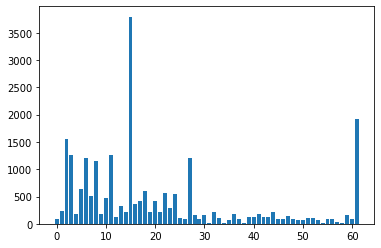

In [37]:
stds = []

for i in range(len(alphabet)):
    
    stds += [np.std(deltas[i * n_queries : (i + 1) * n_queries])]
    
_ = plt.bar(range(len(alphabet)), stds)

In [38]:
print(f"Next character guess: {np.argmax(stds)}")

Next character guess: 15


Still wrong! (Again, notice how the standard deviation is worse because of outliers!) Clearly a naive approach is not going to work here.

## Gaussian Mixture Model Approach (Fast)

Now we can try our more technical approach to see if it yields more accurate results.

In [39]:
deltas_clean = list(filter(lambda delta: (delta > delta_range[0]) and (delta < delta_range[1]), deltas))

gmm = GaussianMixture(n_components=2)
_ = gmm.fit(np.array(deltas_clean).reshape(-1, 1))

print(f"Means: {gmm.means_[0, 0]}, {gmm.means_[1, 0]}")
print(f"Variances: {gmm.covariances_[0, 0, 0]}, {gmm.covariances_[1, 0, 0]}")
print(f"Weights: {gmm.weights_[0]}, {gmm.weights_[1]}")

Means: -0.2084185273630874, -1.6999707257079035
Variances: 0.8360879997709824, 132.6629931377934
Weights: 0.6973255204467007, 0.3026744795533111


These results seem a little wierd. Let's take a look at the resulting PDFs.

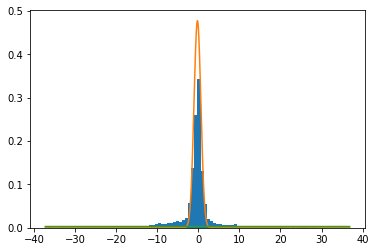

In [40]:
_ = plt.hist(deltas, range=delta_range, bins=100, density=True)

xx = np.arange(delta_range[0], delta_range[1], 0.01)

_ = plt.plot(xx, scipy.stats.norm.pdf(xx, gmm.means_[0,0], gmm.covariances_[0,0,0]))
_ = plt.plot(xx, scipy.stats.norm.pdf(xx, gmm.means_[1,0], gmm.covariances_[1,0,0]))

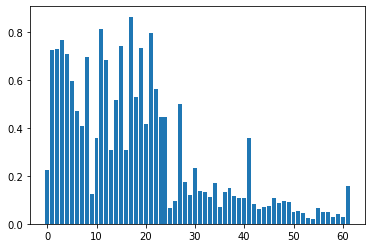

In [41]:
correct_distribution = np.argmin(gmm.weights_)

probs = []

for i in range(len(alphabet)):
    
    if correct_distribution == 1:
        probs += [np.sum(gmm.predict(np.array(deltas[i * n_queries : (i + 1) * n_queries]).reshape(-1, 1))) / n_queries]
    else:
        probs += [np.sum(1 - gmm.predict(np.array(deltas[i * n_queries : (i + 1) * n_queries]).reshape(-1, 1))) / n_queries]

_ = plt.bar(range(0, len(alphabet)), probs)

In [42]:
print(f"Next character guess: {np.argmax(probs)}")

Next character guess: 17


It appears that the Gaussian mixture didn't do much better than the naive approach!